# Iris — ML Governance Assignment (GCP-Ready)

In [1]:
!pip install -q pandas scikit-learn shap fairlearn xgboost matplotlib scipy lime

In [2]:

import numpy as np, pandas as pd, json, os
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from fairlearn.metrics import MetricFrame, selection_rate, true_positive_rate, false_positive_rate, demographic_parity_difference, equalized_odds_difference
import shap
from scipy import stats

try:
    from lime.lime_tabular import LimeTabularExplainer
    LIME_AVAILABLE = True
except Exception:
    LIME_AVAILABLE = False

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
ARTIFACT_DIR = Path("artifacts"); ARTIFACT_DIR.mkdir(exist_ok=True)


In [3]:

from pathlib import Path
csv_path = Path('iris.csv')
if csv_path.exists():
    df = pd.read_csv(csv_path)
else:
    from sklearn.datasets import load_iris
    iris = load_iris(as_frame=True)
    df = iris.frame.rename(columns={
        'sepal length (cm)':'sepal_length','sepal width (cm)':'sepal_width',
        'petal length (cm)':'petal_length','petal width (cm)':'petal_width',
        'target':'species'
    })
    target_names = dict(enumerate(iris.target_names))
    df['species'] = df['species'].map(target_names)

df['location'] = np.random.randint(0,2,size=len(df)).astype(int)
display(df.head())
print(df['species'].value_counts())


,sepal_length,sepal_width,petal_length,petal_width,species,location
0,5.1,3.5,1.4,0.2,setosa,0
1,4.9,3.0,1.4,0.2,setosa,1
2,4.7,3.2,1.3,0.2,setosa,0
3,4.6,3.1,1.5,0.2,setosa,0
4,5.0,3.6,1.4,0.2,setosa,0


species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64


In [4]:

numeric = ['sepal_length','sepal_width','petal_length','petal_width']
sensitive = 'location'; target='species'
Xb = df[numeric].copy(); Xv = df[numeric+[sensitive]].copy(); y = df[target].copy()

def train_pipeline(X, y, label):
    Xtr, Xte, ytr, yte = train_test_split(X, y, stratify=y, test_size=0.25, random_state=RANDOM_STATE)
    prep = ColumnTransformer([('num', StandardScaler(), X.columns)], remainder='drop')
    clf = RandomForestClassifier(n_estimators=400, random_state=RANDOM_STATE)
    pipe = Pipeline([('prep', prep), ('clf', clf)]).fit(Xtr,ytr)
    ypred = pipe.predict(Xte)
    print(f"[{label}] acc:", accuracy_score(yte, ypred)); print(classification_report(yte, ypred))
    return pipe, Xtr, Xte, ytr, yte

mdl_b, Xb_tr, Xb_te, yb_tr, yb_te = train_pipeline(Xb, y, "baseline")
mdl_v, Xv_tr, Xv_te, yv_tr, yv_te = train_pipeline(Xv, y, "with_location")


[baseline] acc: 0.8947368421052632
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        12
  versicolor       0.80      0.92      0.86        13
   virginica       0.91      0.77      0.83        13

    accuracy                           0.89        38
   macro avg       0.90      0.90      0.90        38
weighted avg       0.90      0.89      0.89        38

[with_location] acc: 0.9473684210526315
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        12
  versicolor       0.92      0.92      0.92        13
   virginica       0.92      0.92      0.92        13

    accuracy                           0.95        38
   macro avg       0.95      0.95      0.95        38
weighted avg       0.95      0.95      0.95        38



In [5]:

def fairness_report(model, Xte, yte, label, has_location):
    is_virg = (yte=='virginica').astype(int)
    proba = model.predict_proba(Xte)
    cls_idx = list(model.named_steps['clf'].classes_).index('virginica')
    pred = (proba[:,cls_idx]>=0.5).astype(int)
    s = Xte['location'] if has_location else df.loc[Xte.index,'location']
    mf = MetricFrame(
        metrics={'selection_rate': selection_rate, 'tpr': true_positive_rate, 'fpr': false_positive_rate},
        y_true=is_virg, y_pred=pred, sensitive_features=s
    )
    dp = demographic_parity_difference(y_true=is_virg, y_pred=pred, sensitive_features=s)
    eo = equalized_odds_difference(y_true=is_virg, y_pred=pred, sensitive_features=s)
    display(mf.by_group)
    print(label, "DP:", dp, "EO:", eo)
    return {'by_group': mf.by_group.to_dict(),'dp_diff': float(dp),'eo_diff': float(eo)}

fair_b = fairness_report(mdl_b, Xb_te, yb_te, "baseline", has_location=False)
fair_v = fairness_report(mdl_v, Xv_te, yv_te, "with_location", has_location=True)


,selection_rate,tpr,fpr
location,,,
0,0.333333,0.75,0.000000
1,0.250000,0.80,0.066667


baseline DP: 0.08333333333333331 EO: 0.06666666666666667


,selection_rate,tpr,fpr
location,,,
0,0.444444,1.0,0.000000
1,0.250000,0.8,0.066667


with_location DP: 0.19444444444444442 EO: 0.19999999999999996


In [8]:
numeric_cols = ['sepal_length','sepal_width','petal_length','petal_width']
all_numeric = numeric_cols + ['location']

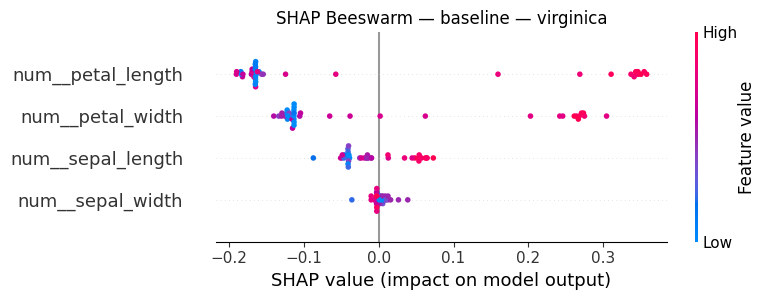

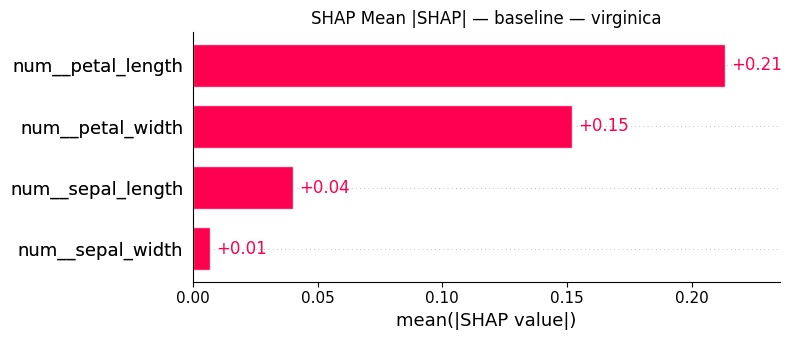

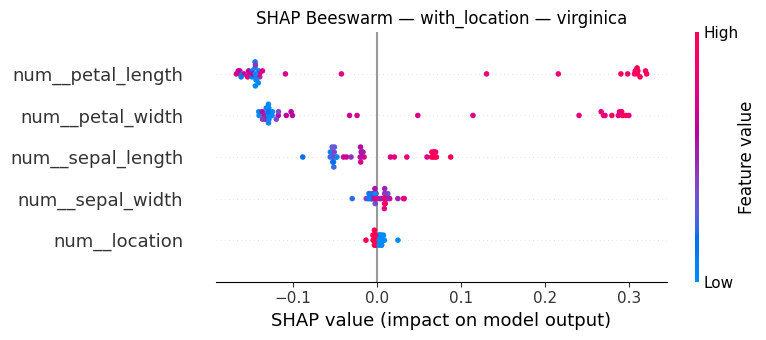

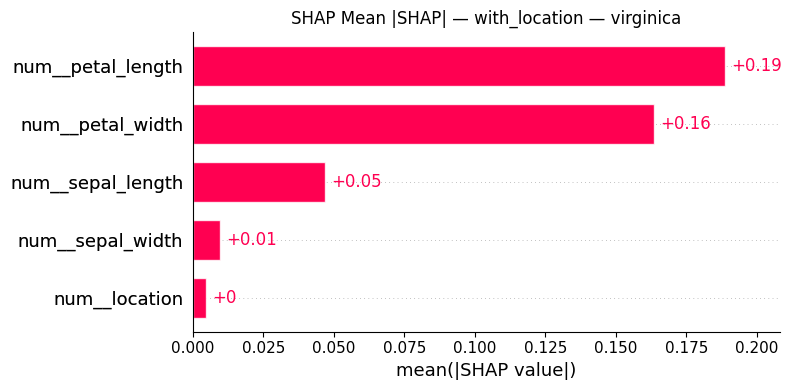

Saved figs: artifacts/shap_beeswarm_baseline.png artifacts/shap_bar_baseline.png artifacts/shap_beeswarm_with_location.png artifacts/shap_bar_with_location.png


In [10]:

from pathlib import Path
def shap_global_plots(model, Xtr, Xte, label):
    Xtr_d = model.named_steps['prep'].transform(Xtr)
    Xte_d = model.named_steps['prep'].transform(Xte)
    Xtr_d = Xtr_d.toarray() if hasattr(Xtr_d,'toarray') else Xtr_d
    Xte_d = Xte_d.toarray() if hasattr(Xte_d,'toarray') else Xte_d
    try:
        names = model.named_steps['prep'].get_feature_names_out().tolist()
    except Exception:
        names = list(Xtr.columns)
    expl = shap.Explainer(model.named_steps['clf'], Xtr_d, feature_names=names, model_output='probability')
    ex = expl(Xte_d)
    v_idx = list(model.named_steps['clf'].classes_).index('virginica')
    ex_v = shap.Explanation(values=ex.values[:,:,v_idx],
                            base_values=(ex.base_values[:,v_idx] if getattr(ex.base_values,'ndim',1)==2 else ex.base_values),
                            data=ex.data, feature_names=ex.feature_names)
    shap.plots.beeswarm(ex_v, show=False); plt.title(f"SHAP Beeswarm — {label} — virginica")
    ARTIFACT_DIR = Path("artifacts"); ARTIFACT_DIR.mkdir(exist_ok=True)
    p1 = ARTIFACT_DIR / f"shap_beeswarm_{label}.png"; plt.tight_layout(); plt.savefig(p1, dpi=160); plt.show()
    shap.plots.bar(ex_v, show=False); plt.title(f"SHAP Mean |SHAP| — {label} — virginica")
    p2 = ARTIFACT_DIR / f"shap_bar_{label}.png"; plt.tight_layout(); plt.savefig(p2, dpi=160); plt.show()
    return str(p1), str(p2)

fig_b1, fig_b2 = shap_global_plots(mdl_b, Xb_tr, Xb_te, "baseline")
fig_v1, fig_v2 = shap_global_plots(mdl_v, Xv_tr, Xv_te, "with_location")
print("Saved figs:", fig_b1, fig_b2, fig_v1, fig_v2)


In [11]:

# (Optional) LIME
if 'LIME_AVAILABLE' in globals() and LIME_AVAILABLE:
    model = mdl_v; Xtr, Xte = Xv_tr, Xv_te
    prep = model.named_steps['prep']; clf = model.named_steps['clf']
    Xtr_d = prep.transform(Xtr); Xte_d = prep.transform(Xte)
    Xtr_d = Xtr_d.toarray() if hasattr(Xtr_d,'toarray') else Xtr_d
    Xte_d = Xte_d.toarray() if hasattr(Xte_d,'toarray') else Xte_d
    try: names = prep.get_feature_names_out().tolist()
    except Exception: names = list(Xtr.columns)
    explainer = LimeTabularExplainer(training_data=np.array(Xtr_d), feature_names=names, class_names=list(clf.classes_), discretize_continuous=True, random_state=42)
    exp = explainer.explain_instance(data_row=np.array(Xte_d[0]), predict_fn=lambda X: clf.predict_proba(X))
    p = Path('artifacts/lime_with_location_example.html'); exp.save_to_file(str(p)); print("Saved LIME to:", p)
else:
    print("LIME not installed; skipping.")


Saved LIME to: artifacts/lime_with_location_example.html


In [12]:

from scipy import stats
def compute_psi(expected, actual, bins=10, eps=1e-6):
    quantiles = np.linspace(0,100,bins+1); cut = np.unique(np.percentile(expected, quantiles))
    if len(cut) < 3: cut = np.linspace(min(expected.min(), actual.min()), max(expected.max(), actual.max()), bins+1)
    e_counts,_ = np.histogram(expected, bins=cut); a_counts,_ = np.histogram(actual, bins=cut)
    e_perc = e_counts / max(e_counts.sum(), eps); a_perc = a_counts / max(a_counts.sum(), eps)
    e_perc = np.clip(e_perc, eps, None); a_perc = np.clip(a_perc, eps, None)
    return np.sum((a_perc - e_perc) * np.log(a_perc / e_perc))

def drift_report(train_df, test_df, numeric_cols):
    rows = []
    for col in numeric_cols:
        exp = train_df[col].values; act = test_df[col].values
        psi = compute_psi(exp, act, bins=10)
        ks_stat, ks_p = stats.ks_2samp(exp, act)
        rows.append({'feature': col, 'psi': psi, 'ks_stat': ks_stat, 'ks_pvalue': ks_p})
    return pd.DataFrame(rows)

train_df = pd.DataFrame(Xv_tr, columns=Xv_tr.columns)
test_df  = pd.DataFrame(Xv_te, columns=Xv_te.columns)
drift_df = drift_report(train_df, test_df, numeric + [sensitive])
display(drift_df); drift_df.to_csv('artifacts/drift_report.csv', index=False)
print("Saved drift report to artifacts/drift_report.csv")


,feature,psi,ks_stat,ks_pvalue
0,sepal_length,0.229550,0.108083,0.854304
1,sepal_width,1.021896,0.082237,0.979957
2,petal_length,0.408701,0.113252,0.808026
3,petal_width,1.139781,0.092105,0.946939
4,location,0.002991,0.027256,1.000000


Saved drift report to artifacts/drift_report.csv


In [13]:

# Save metrics.json, model_card.md, datasheet.md with safe string building
metrics = {}
def collect_metrics(label, model, Xte, yte, fair):
    acc = float(accuracy_score(yte, model.predict(Xte)))
    metrics[label] = {'accuracy': acc, 'fairness': fair}

collect_metrics('baseline', mdl_b, Xb_te, yb_te, fair_b)
collect_metrics('with_location', mdl_v, Xv_te, yv_te, fair_v)

Path('artifacts').mkdir(exist_ok=True)
with open('artifacts/metrics.json','w') as f: json.dump(metrics, f, indent=2)

metrics_json = json.dumps(metrics, indent=2)
mc_lines = []
mc_lines.append("# Model Card — Iris Classifier")
mc_lines.append("")
mc_lines.append("## Overview")
mc_lines.append("- Task: Multiclass classification (setosa, versicolor, virginica)")
mc_lines.append("- Data: Iris dataset with synthetic sensitive attribute 'location' in {0,1} added at random for fairness auditing.")
mc_lines.append("- Models compared: baseline (excludes location), with_location (includes location).")
mc_lines.append("")
mc_lines.append("## Metrics (test split)")
mc_lines.append("```")
mc_lines.append(metrics_json)
mc_lines.append("```")
mc_lines.append("")
mc_lines.append("## Fairness")
mc_lines.append("- Sensitive attribute: location (synthetic). Reported for class 'virginica' via one-vs-rest: selection rate, TPR, FPR, demographic parity difference, equalized odds difference.")
mc_lines.append("")
mc_lines.append("## Explainability")
mc_lines.append("- Global: SHAP beeswarm and mean |SHAP| plots for 'virginica'. Local: LIME example (if installed).")
mc_lines.append("")
mc_lines.append("## Drift")
mc_lines.append("- Simple PSI and K-S checks between train and test; in production compare train vs recent production windows and alert on thresholds (e.g., PSI > 0.25).")
mc_lines.append("")
mc_lines.append("## Limitations")
mc_lines.append("- Small dataset; fairness gaps may be unstable. 'location' is random; threshold=0.5 chosen for demo.")
mc_text = "\n".join(mc_lines)
open('artifacts/model_card.md','w').write(mc_text)

ds_lines = []
ds_lines.append("# Datasheet — Iris (with synthetic 'location')")
ds_lines.append("## Composition")
ds_lines.append("- Features: sepal_length, sepal_width, petal_length, petal_width; Label: species; Sensitive attribute: location in {0,1} (random).")
ds_lines.append("## Collection")
ds_lines.append("- Iris from scikit-learn or local iris.csv. location assigned at random with seed 42.")
ds_lines.append("## Recommended Uses")
ds_lines.append("- Fairness, explainability, drift demos.")
open('artifacts/datasheet.md','w').write("\n".join(ds_lines))

print("Saved artifacts:")
print("- artifacts/metrics.json")
print("- artifacts/model_card.md")
print("- artifacts/datasheet.md")


Saved artifacts:
- artifacts/metrics.json
- artifacts/model_card.md
- artifacts/datasheet.md
